## Random Forest

Random Forest aplicado ao mercado de crédito.


In [36]:
### Importando bibliotecas
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile ## biblioteca para descompactar arquivo .zip

Os dados foram coletado da plataforma Kaggle e são disponibilizados via arquivo zipado, portanto devemos extrar os arquivos

In [2]:
path = 'archive.zip' ## nome do arquivo .zip

## Usando ZipFile para extrair
with ZipFile(path, mode="r") as f:
    ## Listando os nomes dos arquivos
    file_names = f.namelist() 
    print(file_names)
    ## Extraindo arquivos
    f.extractall()

['customer_data.csv', 'payment_data.csv']


### Analise e manipulação de dados

In [3]:
### Importando dados
customer = pd.read_csv('customer_data.csv')
customer.head()


,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [4]:
payment = pd.read_csv('payment_data.csv')
payment.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_2   976 non-null    float64
 4   fea_3   1125 non-null   int64  
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   int64  
 7   fea_6   1125 non-null   int64  
 8   fea_7   1125 non-null   int64  
 9   fea_8   1125 non-null   int64  
 10  fea_9   1125 non-null   int64  
 11  fea_10  1125 non-null   int64  
 12  fea_11  1125 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [6]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8250 non-null   int64  
 1   OVD_t1           8250 non-null   int64  
 2   OVD_t2           8250 non-null   int64  
 3   OVD_t3           8250 non-null   int64  
 4   OVD_sum          8250 non-null   int64  
 5   pay_normal       8250 non-null   int64  
 6   prod_code        8250 non-null   int64  
 7   prod_limit       2132 non-null   float64
 8   update_date      8224 non-null   object 
 9   new_balance      8250 non-null   float64
 10  highest_balance  7841 non-null   float64
 11  report_date      7136 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


In [7]:
customer.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [8]:
payment.describe()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,34.000000,34.000000,35.000000,31500.000000,36.000000,27.000000,660000.000000,1.632120e+08,1.800005e+08


Consultando quantidade de valores nulos e outliers 

In [9]:
print(customer.isnull().sum())
print('\n')
print(payment.isnull().sum())

label       0
id          0
fea_1       0
fea_2     149
fea_3       0
fea_4       0
fea_5       0
fea_6       0
fea_7       0
fea_8       0
fea_9       0
fea_10      0
fea_11      0
dtype: int64


id                    0
OVD_t1                0
OVD_t2                0
OVD_t3                0
OVD_sum               0
pay_normal            0
prod_code             0
prod_limit         6118
update_date          26
new_balance           0
highest_balance     409
report_date        1114
dtype: int64


In [10]:
#### Substituindo valores nulos
for col in customer.columns:
    if customer[col].isnull().sum() > 0:
        customer[col].fillna(customer[col].mean(), inplace=True)

### Processamento de dados

Em geral esses tipos de dados são desbalanceados, ou seja, terá bem mais observações de um respectivo dado dentro da amostra.
Um exemplo de dados desbalanceados seria uma caixa de email, onde 99% dos emails que chagam são emails "limpos" (não nenhum tipo de má intensão) e apenas 1% dos emails são spam. Dessa maneira seria possível treinar um modelo de ML com esses dados que possuiria uma acurácia de 99%, neste caso ele poderia te recomendar todos os emails que chegam em sua caixa, juntamente com os emails maliciosos. Este é o problema de trabalhar com dados desbalanceados.

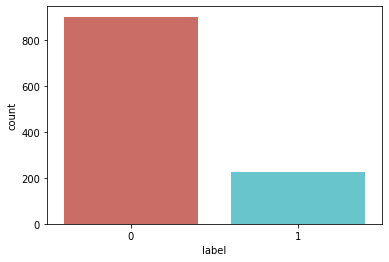

In [18]:
### Contando targets
sns.countplot(x='label', data=customer, palette='hls')
plt.show()

In [24]:
### Criando variaveis dos dados
X = customer.drop(['label'], axis=1)
y = customer['label']

In [26]:
### Aplicando SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

c:\Users\Jhona\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


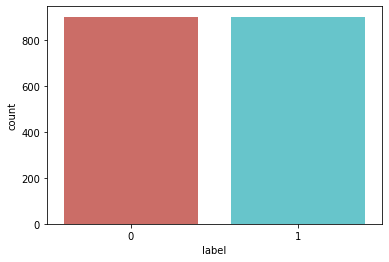

In [28]:
### Conatando dados
sns.countplot(y_res, palette='hls')
plt.show()

### Preparando modelo

In [29]:
### Normalizando dados
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

In [30]:
### Separando dados
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.3, random_state=42)

In [32]:
### Randon Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)




In [34]:
### Testando a acuracia
acuracia = accuracy(y_test, y_pred)
rmse_test = MSE(y_test, y_pred)**0.5
print('Acuracia: ', acuracia)
print('RMSE: ', rmse_test)

Acuracia:  0.8648148148148148
RMSE:  0.36767538017276213


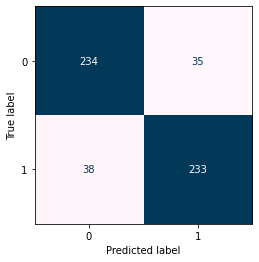

In [42]:
### Analisando a matriz de confusao
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='PuBu', colorbar=False)

In [49]:
### Report de classificacao
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       269
           1       0.87      0.86      0.86       271

    accuracy                           0.86       540
   macro avg       0.86      0.86      0.86       540
weighted avg       0.86      0.86      0.86       540



<AxesSubplot:>

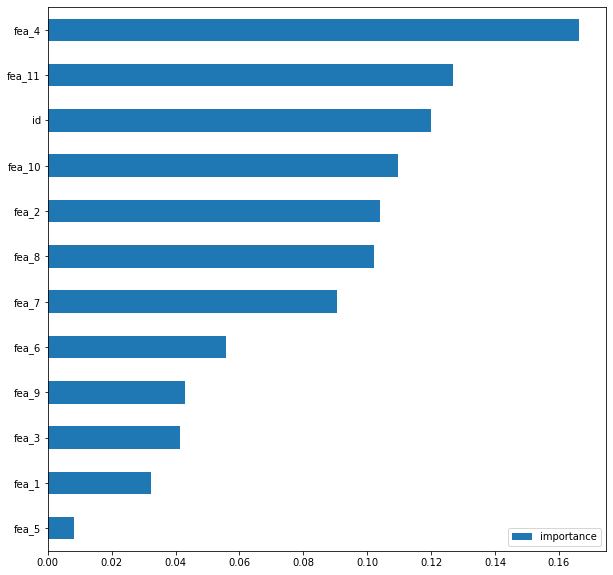

In [48]:
### Analisando fatores de importancia
importances = rf.feature_importances_
importances = pd.DataFrame(importances, index=X.columns, columns=['importance'])
importances.sort_values(by='importance', ascending=True, inplace=True)
importances.plot(kind='barh',figsize=(10, 10))